# Transformer Teardown: Llama 3.1

> Trace an Inference Through Each Layer of the SOTA Llama 3.1 Foundation Models

In [the last Transformer Teardown](https://stickshift.github.io/2024/09/04/transformer-teardown.html), we dissected a DistilBERT text classification pipeline, tracing a single inference through the entire stack from raw data to final prediction. We learned about the main stages of a Transformer pipeline as well as fundamental Transformer concepts such as token embeddings and Multi-Head Self Attention. Studying BERT-based text classification models is a fantastic way to see the basic Transformer machinery in action. But BERT was published in 2018! It would be another 4 years before ChatGPT launched and Generative AI exploded onto the scene.

In this Transformer Teardown, we're going to fast forward to present day. We'll use the same teardown process to unpack the state-of-the-art [Llama 3.1](https://llama.meta.com/) open source foundation models released by Meta in July. We'll walk through each step of a text generation pipeline one cell at a time, tracing an inference from raw text to the first output token. We'll illustrate the main ideas from the latest Transformer literature with minimal, straightforward, working Python code, giving you a close-up view of the core mechanisms driving the Generative AI revolution.

# Setup

In [1]:
from functools import partial
import json
import math
import os
from pathlib import Path
from sys import stdout
from textwrap import dedent
import warnings

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pandas import Series
from pydantic import BaseModel, validate_call
from pytest import approx
from tqdm import tqdm

import torch
from torch import nn, Tensor
from torch.nn.functional import relu, silu, softmax

from llama_models.llama3.reference_impl.model import RMSNorm

import stickshift as ss
from stickshift import default_arg, take
from stickshift.torch import device as torch_device

In [2]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Configure gpu
device = torch_device()

# Torch display options
torch.set_printoptions(linewidth=120)

In [3]:
%%html
<style>
figure > img {
    display:block;
    margin-left: auto !important;
    margin-right: auto !important;
}
figcaption {
    text-align: center;
}
blockquote {
    margin-top: 2.0rem !important;
    margin-bottom: 2.0rem !important;
    margin-left: 0 !important;
    margin-right: 0 !important;
    padding: 1.0rem !important;
    background-color: rgba(0,0,0,0.05) !important;
    border: 1px solid rgba(0,0,0,0.1) !important;
    font-style: italic !important;
}
blockquote p {
    margin: 0 !important;
    padding: 0 !important;
}
</style>

In [4]:
%pprint

Pretty printing has been turned OFF


# Llama Foundation Models

[Llama](https://llama.meta.com/) is a family of general purpose, state-of-the-art open source foundation models from Meta. According to the 3.1 technical report, the latest models can "answer questions in at least 8 languages, write high quality code, solve complex reasoning problems, and use tools in a zero-shot way." (Dubey et al. 2024) The Llama 3.1 release includes 8B, 70B, and 405B sizes. While you need a multi-GPU cluster to run the 70B and 405B sizes, the 8B model is small enough to experiment with on a laptop. Not only did Meta release the pre-trained model checkpoints for all 3 sizes, they also published a fantastically detailed, [70 page technical report](https://arxiv.org/abs/2407.21783v2) as well as a complete [reference implementation](https://github.com/meta-llama/llama-models). Together, Llama 3.1 represents both a tremendous contribution to the AI community as well as an incredible learning opportunity to study the inner workings of a modern frontier model.

Over the course of this post, we'll implement a complete text generation pipeline using only the research literature, pre-trained weights from the `Meta-Llama3.1-8B-Instruct` checkpoint, and Meta's reference implementation as a guide. After we load the 8B checkpoint, we'll review the stages of an end-to-end, text generation pipeline. In the sections that follow, we'll walk through a detailed teardown of each stage—tracing an inference from raw data to the first output token. In the last section, we'll put all the pieces together into a complete generative Transformer capable of producing long form content.

Let the teardown begin!

# Model Checkpoint

We'll start by loading the configuration and pre-trained weights for the `Meta-Llama3.1-8B-Instruct` checkpoint. The "instruct" versions of the Llama models include the raw pre-training and substantial post-training to support user and assistant interactions and complex tool-calling scenarios. The weights for all Llama checkpoints can be downloaded directly from [Meta](https://llama.meta.com/), [Hugging Face](https://huggingface.co/meta-llama), and [Kaggle](https://www.kaggle.com/organizations/metaresearch/models).

In [5]:
# Import custom utilities
from stickshift.models import llama

# Load model config
config = llama.config("Meta-Llama3.1-8B-Instruct")

# Load pre-trained model parameters
checkpoint = torch.load(
    config.checkpoint_path / "consolidated.00.pth", 
    weights_only=True, 
    map_location=device,
)

config.model_dump()

{'checkpoint_path': PosixPath('/Users/andrewyoung/.llama/checkpoints/Meta-Llama3.1-8B-Instruct'), 'vocab_size': 128256, 'd_model': 4096, 'd_head': 128, 'd_ffn': 14336, 'n_layers': 32, 'n_heads': 32, 'n_kv_heads': 8, 'rms_norm_eps': 1e-05, 'rope_theta': 500000.0, 'max_seq_len': 8192, 'temperature': 0.6, 'top_k': 50, 'top_p': 0.9, 'max_output_tokens': 500}

We'll reference a number of the settings in `config` throughout the teardown. For now, a few interesting ones to note are `d_model`, `d_ffn`, `n_layers`, and `n_heads`. These represent the primary differences between the 8B, 70B, and 405B sizes.

In [6]:
def load_pretrained_state(layer):    
    # Load pre-trained state
    llama.load_state(
        normalize_attention, "normalize_attention", 
        normalize_ffn, "normalize_ffn", 
        W_q, "w_q", 
        W_k, "w_k", 
        W_v, "w_v", 
        attention_outputs, "attention_outputs",
        ffn_gates, "ffn_gates",
        ffn_inputs, "ffn_inputs",
        ffn_outputs, "ffn_outputs",
        checkpoint=checkpoint,
        layer=layer,
    ) 

# Text Generation Pipeline

In [the last teardown](https://stickshift.github.io/2024/09/04/transformer-teardown.html), we looked at a text classification Transformer. This time we're going to dissect a *text generation* Transformer. Instead of simply applying a label to the input text, the Head stage will be responsible for *generating* new content. But don't worry! It's not as complicated as it sounds.

Figure 1 illustrates the stages in a text generation pipeline. It's very similar to the text classification pipeline we looked at last time. The Tokenize stage splits raw text into a sequence of tokens. The Embeddings stage maps the sequence of tokens to a sequence of embedding vectors. The Context Layers augment the embeddings with contextual signals drawn from the surrounding tokens, transforming individual token embeddings into contextualized "semantic embeddings". Finally, the Head stage converts the semantic embeddings into predictions. The key difference is, instead of predicting a label for the raw text, text generation Transformers *predict the next token*.

<figure>
<img src="transformer-pipeline.svg" width="940">
<figcaption>Figure 1: Text Generation Pipeline</figcaption>
</figure>

But one token is just the beginning! The magical powers of Generative AI are manifested by simply running the token predictions in a loop. The predicted token in each iteration is appended to the end of the input sequence, and the process repeats. Over and over again.

# Raw Text

Before we can tear anything down, we need a prompt. Since our goal is to trace an inference from raw text to the first output token, we want to start with a prompt that's specific enough to generate a consistent, one-word answer. If we do everything right, the first output token we predict should be "Boston".

In [7]:
# Prompt
prompt = "<|start_header_id|>user<|end_header_id|>\n\n"
prompt += "What is the capital of Massachusetts? Answer in one word."
prompt += "<|eot_id|>"
prompt += "<|start_header_id|>assistant<|end_header_id|>\n\n"

You can see `prompt` includes a number of special tokens. These would usually be injected by a framework like Hugging Face's `transformers`. We need to manually inject them because we're working with the model directly. You can find more information on the Llama 3.1 prompt syntax in the [Llama Prompting Guide](https://www.llama.com/docs/how-to-guides/prompting).

# Tokenize

The Tokenize stage splits raw text into a sequence of tokens using a fixed vocabulary. Llama uses a vocabulary of 128k tokens built on top of OpenAI's tiktoken tokenizer. We'll dig into the gory details in the later stages, but here we'll simply use the off-the-shelf Tokenizer from Meta's llama-models reference implementation.

In [8]:
from llama_models.llama3.api.tokenizer import Tokenizer

# Load tokenizer model from checkpoint
tokenizer = Tokenizer(str(config.checkpoint_path / "tokenizer.model"))

In [9]:
# Split raw text into tokens
token_ids = tokenizer.encode(prompt, bos=True, eos=False, allowed_special="all")
token_ids

[128000, 128006, 882, 128007, 271, 3923, 374, 279, 6864, 315, 22108, 30, 22559, 304, 832, 3492, 13, 128009, 128006, 78191, 128007, 271]

In [10]:
len(token_ids)

22

We see `tokenizer.encode` split our prompt into 22 token ids. These ids represent the index of each token in Llama's 128k token vocabulary. We can always reverse the process with `tokenizer.decode`. If you look closely at the cell output below, you'll notice the tokenizer injected another special token `(128000, '<|begin_of_text|>')` to mark the beginning of the sequence.

In [11]:
# Decode token ids back into raw text
tokenizer.decode(token_ids)

'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nWhat is the capital of Massachusetts? Answer in one word.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'

In [12]:
# Load token_ids into a tensor
X = torch.tensor(token_ids, device=device)

X.shape

torch.Size([22])

# Embeddings

Embeddings are a key component of the Transformer architecture. They're also abstract mathematical structures that can be difficult to wrap your head around. To illustrate the crucial role embeddings play, let's use a quick metaphor.

> If a Transformer was a brain, then embeddings would be the electrical signals carrying information through the brain.

Continuing with the metaphor, the Embeddings stage of the pipeline would be your sensory organs where light rays and air vibrations are translated into electrical impulses. Token embeddings would be the fresh sensory percepts. Semantic embeddings would be the abstract thoughts at the top of the cortical stack. The idea of percepts traveling up the cortical stack is a perfect analogy for token embeddings traveling through the Transformer layers.

Implementing Llama's Embeddings stage is relatively straightforward. We'll use a lookup table with a unique embedding for each of the 128k tokens in the vocabulary. Each embedding is a vector with $d_{model}$ elements that were randomly generated and then learned during training. Given a sequence of token ids, the lookup table returns their embeddings as row vectors stacked in an $n \times d_{model}$ tensor. 

<figure>
<img src="embeddings.svg" width="940">
<figcaption>Figure 2: Learned Token Embeddings</figcaption>
</figure>

In [13]:
# Initialize embeddings lookup table
embeddings = nn.Embedding(
    num_embeddings=config.vocab_size, 
    embedding_dim=config.d_model,
    device=device,
)

# Load pre-trained state
llama.load_state(embeddings, "embeddings", checkpoint=checkpoint)

In [14]:
# Map token ids to embeddings
X = embeddings(X)

X.shape

torch.Size([22, 4096])

We can see from `X.shape` that we successfully mapped the 22 token ids to 22 token embeddings stacked in an $n \times d_{model}$ tensor.

In [15]:
# Show sample
X

tensor([[ 2.6512e-04, -4.9973e-04, -5.8365e-04,  ...,  3.8147e-03,  6.3419e-05,  1.1902e-03],
        [-1.6499e-04, -2.4319e-04,  1.6403e-04,  ..., -1.5163e-04,  3.5095e-04,  7.3242e-04],
        [ 3.5095e-03,  7.2021e-03,  5.3406e-05,  ..., -7.2479e-04, -1.0620e-02,  8.2779e-04],
        ...,
        [-9.7656e-03, -3.4637e-03,  1.8616e-03,  ..., -7.1411e-03, -4.3030e-03,  8.6060e-03],
        [-4.6158e-04, -3.9291e-04, -6.5863e-06,  ..., -6.2561e-04, -5.0354e-04,  6.6757e-04],
        [-2.8687e-03,  3.8910e-03, -1.7357e-04,  ...,  8.0872e-04,  5.0354e-04,  2.3041e-03]], device='mps:0',
       grad_fn=<EmbeddingBackward0>)

Before we move on, a quick note on terminology. If you've used cloud-based LLM APIs like OpenAI or LangChain, you're likely familiar with the term "embedding model". An *embedding model* is really a combination of a tokenizer and embeddings table. These are often bundled together to give you everything you need to convert raw text into embedding vectors and can be used for a number of things independent of the LLM.

Now that we've converted our raw text into token embeddings, it's time to start transforming!

# Context Layers

Context layers are where the Transformer magic happens. Collectively, the Context Layers are responsible for transforming a sequence of token embeddings into a sequence of semantic embeddings. The mechanism works by passing the embeddings through multiple layers of attention and feedforward blocks. The attention blocks focus on relationships between embeddings, augmenting each one with a weighted combination of the surrounding embeddings. The feedforward blocks capitalize on the extra context, transforming each augmented embedding with the non-linear magic of a fully-connected multilayer perceptron. By stacking multiple layers together, Transformers repeat the pattern of attention and transformation, gradually converting representations of individual words into representations of abstract semantic concepts.

<figure>
<img src="transformer-layers.svg" width="940">
<figcaption>Figure 3: Context Layers</figcaption>
</figure>

Figure 3 illustrates the flow of information through a single layer. Embeddings are first passed to the Attention block. The attention outputs are added to the attention inputs before being passed to the FFN block. Similarly, the FFN outputs are added to the FFN inputs before being passed to the next layer. Adding the inputs and outputs of each block is known as "residual learning" and is critical for providing a stable path for gradient flow during training (He et al. 2015).

## Decoder-Only Model Architecture

Like most of today's generative models, Llama uses a "decoder-only" model architecture. Instead of using the fully connected self attention we saw in [the DistilBERT teardown](https://stickshift.github.io/2024/09/04/transformer-teardown.html), the context layers in Llama use *masked self attention*. The "decoder-only" term comes from the "Attention is All You Need" paper, where Vaswani et al. described layers of self attention as "encoder layers" and layers of masked self attention as "decoder layers". While Vaswani et al.'s *Vanilla* Transformer architecture processed inputs and outputs with encoder layers and decoder layers respectively, later researchers showed that by adding more compute you could achieve the same goals using a single stack of decoder layers. For a fascinating discussion of how decoders became the dominant architecture, I highly recommend watching [Hyung Won Chung's guest lecture at Stanford on the Future of AI](https://youtu.be/orDKvo8h71o?si=J2sxhYtL9LCd6IRk) from April of this year.

## Attention

Attention is the signature component in the Transformer architecture. In the 7 years since Vaswani et al. published "Attention is All You Need", researchers have experimented with numerous attention variations of all shapes and sizes. Before we jump into the code, we'll quickly review the fundamental concepts behind attention followed by details on the specific approach chosen by the Llama authors.

### What is Attention?

Given our input embeddings are stacked in an $n \times d_{model}$ tensor $\mathbf{X}$, the goal of attention is to map each embedding $\set{\mathbf{x}_m \mid \mathbf{x}_m \in \mathbf{X}}$ to an attention representation $\mathbf{a}_m$ that includes relevant contextual signals drawn from the rest of the embeddings $\set{\mathbf{x}_n \mid \mathbf{x}_n \in \mathbf{X}, n \neq m}$. 

For example, let's imagine we've mapped the sentence `I love New York` to the sequence of token embeddings $\mathbf{x} = [E_{I}, E_{love}, E_{New}, E_{York}]$. The embedding $\mathbf{x}_2$ represents the word "New" *in isolation*. The word "New" can mean a lot of things; many of which have nothing to do with this sentence. Our goal would be to generate an attention representation $\mathbf{a}_2$ containing signals from the other embeddings $\set{E_{I}, E_{love}, E_{York}}$ that would help us create a *better* version of $\mathbf{x}_2$:

$$
\mathbf{x}_{2*} = \mathbf{x}_{2} + \mathbf{a}_{2}
$$

Let's assume each embedding contributes "something" to $\mathbf{a}_m$. Even though we can't quantify "something" yet, we can write $\mathbf{a}_m$ as an unknown function $f_A$ of the two embeddings $\mathbf{x}_m$, $\mathbf{x}_n$:

$$
\mathbf{a}_m = \sum_{\mathbf{x}_n \in \mathbf{X}} f_A(\mathbf{x}_m, \mathbf{x}_n)
$$

All of the attention variations in the Transformer literature—e.g. Self Attention, Multi-Head Self Attention, Linear Attention, Grouped Query Attention—are different approaches to implement $f_A$. In practice, the authors of a new Transformer model start with Vaswani et al.'s attention definition and then select from the large, à la carte menu of improvements that have been published since, resulting in their own unique variation of attention.

### Attention in Llama 3.1

Defining attention in Llama 3.1 requires a bit of backtracking. Most of the details can be found in Llama 1 (Touvron et al. 2023) with a few changes in Llama 2 (Touvron et al. 2023) and only minor adjustments in Llama 3 (Dubey et al. 2024).

Starting with the standard Masked Self Attention definition from Vaswani et al. (2017), Llama adopts the following improvements that affect attention:

* Pre-normalization with RMSNorm: improves training stability and inference speed.
* Grouped Query Attention (GQA) with 8 key/value heads: improves inference speed and reduce memory overhead of key-value caches.
* Rotary Position Embedding (RoPE) with $\Theta = 500,000$: relative position encoding improves performance on longer context windows.

We'll start by describing the standard Masked Self Attention and then describe how these improvements modify the final attention calculation in Llama.

### Masked Self Attention

Given $n$ input embeddings of length $d_{model}$ stacked in an $n \times d_{model}$ tensor $\mathbf{X}$, the standard masked self attention algorithm from Vaswani et al. can be expressed using the following equation:

$$
\begin{equation}
\mathbf{A} = softmax\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_K}} + \mathbf{M}\right)\mathbf{V} \\
\end{equation}
$$

where

* $\mathbf{Q}$, $\mathbf{K}$, and $\mathbf{V}$ are all linear projections of $\mathbf{X}$.
* $\mathbf{Q}$ is an $n \times d_K$ tensor of *queries* that represent selection criteria for surrounding embeddings that would add valuable context to the current representation.
* $\mathbf{K}$ is an $n \times d_K$ tensor of *keys* that represent characteristics that satisfy the selection criteria in the queries.
* $\mathbf{V}$ is an $n \times d_{model}$ tensor of *values* that represent the contextual signals to transfer from one embedding to another.
* The $\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_K}}$ term is an $n \times n$ tensor of "attention weights" that define how much of each embedding's values to include from $\mathbf{V}$.
* $\mathbf{M}$ is an $n \times n$ attention mask that prevents earlier embeddings from attending to later ones by adding a $-\infty$ bias to the later embeddings' scores.
* $\mathbf{A}$ is an $n \times d_{model}$ tensor of attention representations.

The mechanism starts with the $\mathbf{Q}\mathbf{K}^T$ term that calculates the *angular distance* between each query vector $\mathbf{q}_m$ and key vector $\mathbf{k}_n$ by taking their dot product. The smaller the angle, the closer the vectors, and the better the match between $\mathbf{q}_m$ and $\mathbf{k}_n$. The result of the $\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_K}}$ term is an $n \times n$ tensor of raw scores where row $i$ represents query $\mathbf{q}_m$ and column $j$ represents how well key $\mathbf{k}_n$ matches $\mathbf{q}_m$.

The next step is to add the attention mask $\mathbf{M}$ to prevent earlier embeddings from attending to later embeddings. Imagine $\mathbf{M}$ as an $n \times n$ diagonal mask with the upper right half set to $-\infty$ and the lower left set to $0$. Illustrated below, you can see that $\mathbf{q}_0$ can only attend to $\set{\mathbf{k}_0}$, while $\mathbf{q}_1$ can attend to $\set{\mathbf{k}_0, \mathbf{k}_1}$, and $\mathbf{q}_2$ can attend to $\set{\mathbf{k}_0, \mathbf{k}_1, \mathbf{k}_2}$.

<figure>
<img src="attention-mask.svg" width="940">
<figcaption>Figure 4: Attention Mask</figcaption>
</figure>

Next, the $softmax$ term normalizes the attention weights across the keys before they're applied to $\mathbf{V}$.

### Grouped Query Attention (GQA)

Each new token the model generates is compared against every key and value that came before. As context windows grow larger, the memory used by the key and value caches becomes a serious bottleneck. (Ainslie et al. 2023)

To address this bottleneck, Llama 2 replaced the Multi-Head Attention (MHA) mechanism in Llama 1 with technique called Grouped Query Attention (GQA) (Ainslie et al. 2023). In MHA, each attention head has it's own set of queries, keys, and values. Earlier models such as PaLM (Chowdhery et al. 2022) tried replacing MHA with Multi-Query Attention (MQA) which shares a single set of keys and values across all the attention heads. But MQA didn't perform as well as hoped. GQA was designed as a trade-off between the two extremes of MHA and MQA where keys and values *are* shared across attention heads like MQA, but, instead of one group, Llama 3.1 uses 8 key / value heads.

We'll see how GQA is implemented in the upcoming sections on splitting and combining attention heads.

### Rotary Position Embedding (RoPE)

The relevance of one embedding to another is heavily influenced by the distance between them. This makes the embedding positions in the sequence critically important. However, if we recall our unknown attention function $f_A(\mathbf{x}_m, \mathbf{x}_n)$, you may notice the positions are conspicuously missing. This worked for early Transformers like Vanilla and BERT because they encoded the positions directly into the token embeddings $\mathbf{x}_m$, $\mathbf{x}_n$.

More recent models including Llama have adopted *relative* position encoding schemes that have been shown to perform better especially on much longer sequences. Instead of baking the positions into the token embeddings, the idea is to explicitly add the positions $m$, $n$, to our attention function:

$$
f_A(\mathbf{x}_m, \mathbf{x}_n, m, n)
$$

To put this into practice, Llama uses an approach known as Rotary Position Embedding (RoPE) from Su et al. (2021). As we saw earlier, the attention mechanism relies on the angular distance between query and key vectors as a measure of fitness. RoPE intentionally takes advantage of this, converting distance between embedding positions into angular distance between embedding vectors.

This is straightforward to visualize in 2-dimensions. The following diagram shows 2 embeddings $\mathbf{x}_m$ and $\mathbf{x}_n$ with positions $m$ and $n$ respectively. The idea of RoPE is to rotate $\mathbf{x}_m$ a distance of $m \theta$ and $\mathbf{x}_n$ a distance of $n \theta$, directly translating the distance in sequence space $(n - m)$ to a distance in vector space $(\measuredangle{n} - \measuredangle{m})$.

<figure>
<img src="rope.svg" width="940">
<figcaption>Figure 5: RoPE Concept in 2D</figcaption>
</figure>

While the 2-dimensional concept is intuitive, implementing RoPE with $d_{model}$-dimensional vectors is a little more complicated. The complete RoPE algorithm involves several steps. To see what's happening, it helps to unpack and walk through them one at a time.

Let's start by rotating a single embedding. Given an embedding $\mathbf{x}$ with $d$ elements and position $m$, our goal is to rotate $\mathbf{x}$ an angular distance of $m \theta$. Unfortunately, there isn't an exact solution for this when $d$ > 2. Instead, RoPE approximates the idea by splitting $\mathbf{x}$ into pairs $\set{(x_0, x_1), (x_2, x_3), \dots, (x_{d-2}, x_{d-1})}$ and then rotating each pair in 2D.

Given $\mathbf{x}$, $d$, $m$, $\theta$, we can rotate $\mathbf{x}$ an angular distance of $m \theta$ by calculating $\mathbf{R}\mathbf{x}$:

$$
\mathbf{R} \mathbf{x} = 
\begin{bmatrix}
cos(m \theta) & -sin(m \theta) & 0 & 0 \\
sin(m \theta) & cos(m \theta) & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots \\
0 & 0 & cos(m \theta) & -sin(m \theta) \\
0 & 0 & sin(m \theta) & cos(m \theta) \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{d-2} \\
x_{d-1} \\
\end{bmatrix}
=
\begin{bmatrix}
x_0 \cdot cos(m \theta) - x_1 \cdot sin(m \theta) \\
x_0 \cdot sin(m \theta) + x_1 \cdot cos(m \theta) \\
\vdots \\
x_{d-2} \cdot cos(m \theta) - x_{d-1} \cdot sin(m \theta) \\
x_{d-2} \cdot sin(m \theta) + x_{d-1} \cdot cos(m \theta) \\
\end{bmatrix}
$$

Given the sparsity of $\mathbf{R}$, we'll use the compact form recommended by Su et al. (2021). If you compare the compact form below with the right hand side above, you can see they achieve the same result.

Given $\mathbf{x}$, $d$, $m$, $\theta$:

$$
\mathbf{R} \mathbf{x} = 
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{d-2} \\
x_{d-1} \\
\end{bmatrix}
\odot
\begin{bmatrix}
cos(m \theta) \\
cos(m \theta) \\
\vdots \\
cos(m \theta) \\
cos(m \theta) \\
\end{bmatrix}
+
\begin{bmatrix}
-x_1 \\
x_0 \\
\vdots \\
-x_{d-1} \\
x_{d-2} \\
\end{bmatrix}
\odot
\begin{bmatrix}
sin(m \theta) \\
sin(m \theta) \\
\vdots \\
sin(m \theta) \\
sin(m \theta) \\
\end{bmatrix}
$$

Great. We've succeeded at rotating each of the pairs $\set{(x_0, x_1), \dots, (x_{d-2}, x_{d-1})}$ an angular distance $m \theta$. However, RoPE takes position encoding a step further by varying the angular offset $\theta$ across the pairs. The actual equation RoPE uses to rotate a single embedding is the following:

Given $\mathbf{x}$, $d$, $m$, $\Theta$:

$$
\mathbf{R} \mathbf{x} = 
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{d-2} \\
x_{d-1} \\
\end{bmatrix}
\odot
\begin{bmatrix}
cos(m \theta_0) \\
cos(m \theta_0) \\
\vdots \\
cos(m \theta_{d/2-1}) \\
cos(m \theta_{d/2-1}) \\
\end{bmatrix}
+
\begin{bmatrix}
-x_1 \\
x_0 \\
\vdots \\
-x_{d-1} \\
x_{d-2} \\
\end{bmatrix}
\odot
\begin{bmatrix}
sin(m \theta_0) \\
sin(m \theta_0) \\
\vdots \\
sin(m \theta_{d/2-1}) \\
sin(m \theta_{d/2-1}) \\
\end{bmatrix}
$$

where

$$
\theta_i = \frac{1}{\Theta^{2i/d}}, i \in [0, 1, \dots, d/2-1]
$$

Let's visualize $\theta_i$ for $i = [0, d_{head}/2)$ to get a better sense for what's happening here. The following cell plots $\theta_i$ using both the original $\Theta = 10000$ from Su et al. (2021) and the $\Theta = 500000$ from Llama 3.1. Surely the Llama authors must have had a reason to change it, right?

Text(0, 0.5, 'theta_i')

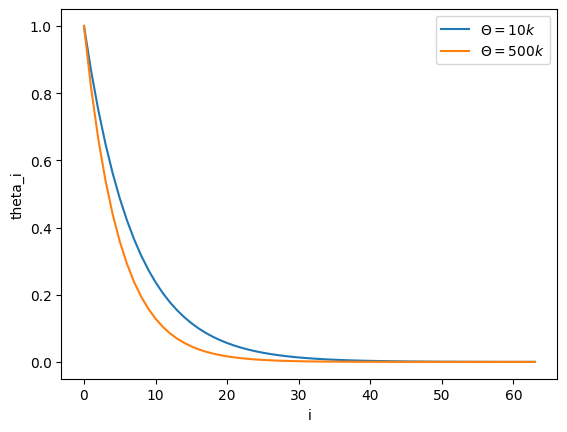

In [16]:
i = torch.arange(config.d_head//2)

thetas = 10000 ** (-2*i / config.d_head)
sns.lineplot(x=i, y=thetas, label=f"$\Theta=10k$")

thetas = 500000 ** (-2*i / config.d_head)
sns.lineplot(x=i, y=thetas, label=f"$\Theta=500k$")

plt.xlabel("i")
plt.ylabel("theta_i")

I'll admit this baffled me for a while. I could understand the rotation idea. *But why would you go through the trouble of varying $\theta$ by what seems like such an arbitrary amount?*

To understand the rationale, we need to step back for a moment and think about the big picture. Why are we using embeddings in the first place? At the end of the day, embeddings are feature vectors. Just like rows in a classical ML master table. Except they literally have thousands of columns. We can't, nor do we want to, know what each one represents. There are simply too many of them. But we do want to support them. Like seeds in a garden, we want to give them nutrient rich soil in which to flourish.

If we rotate all the features by a uniform amount, we're restricting the nutrients in their diet. Some features will be sensitive to distance. The effect of these "short-range" or "local" features may taper off rapidly as the embeddings move apart. Other "long-range" or "global" features will be much less sensitive to distance.

> Varying $\theta$ establishes an environment that encourages a diverse population of short, medium, and long-range features.

### Attention Workflow

Now that we've gone through all of the background, let's rewrite the attention equation one more time with all of the elements we need to calculate.
    
$$
\begin{align}
\mathbf{A} &= softmax\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d}} + \mathbf{M}\right)\mathbf{V} \\
\end{align}
$$


expands to

<div class="small-math">

$$
\begin{align}
\mathbf{A} &= softmax\left(\frac{(\mathbf{R}\mathbf{W}_Q\mathbf{X})(\mathbf{R}\mathbf{W}_K\mathbf{X})^T}{\sqrt{d}} + \mathbf{M}\right)\mathbf{W}_V\mathbf{X} \\
\end{align}
$$

</div>

where

* $\mathbf{W}_Q$, $\mathbf{W}_K$, $\mathbf{W}_V$ are the linear projections for queries, keys, and values respectively.
* $\mathbf{R}\mathbf{W}_Q\mathbf{X}$, $\mathbf{R}\mathbf{W}_K\mathbf{X}$ encode positions by rotating queries and keys respectively.

The flowchart below enumerates the steps required to calculate $\mathbf{A}$. Yes, there are a lot of steps but each one is tiny. My goal was to break the calculation down into small enough pieces that each one is only a few lines of code.

<figure>
<img src="attention-flow.svg" width="700">
<figcaption>Figure 6: Attention Workflow</figcaption>
</figure>

### Normalize Inputs

In the original Transformer architecture, the Attention and FFN blocks normalized the outputs of each sub-layer. In contrast, Llama normalizes the *inputs* to each sub-layer to improve training stability. Furthermore, Llama also replaces the standard LayerNorm algorithm with the RMSNorm algorithm designed by Zhang and Sennrich (2019) to be less computationally expensive and scale better.

In [17]:
# Configure attention normalization
normalize_attention = RMSNorm(config.d_model, config.rms_norm_eps).to(device)

# Load pre-trained weights
llama.load_state(normalize_attention, "normalize_attention", checkpoint=checkpoint)

In [18]:
# Preserve residuals
residual = X

# Normalize attention inputs
X = normalize_attention(X)

X.shape

torch.Size([22, 4096])

### Project Queries, Keys, Values

Next, we'll configure and then apply the linear projections $\mathbf{W}_Q$, $\mathbf{W}_K$, $\mathbf{W}_V$ that map input embeddings $\mathbf{X}$ to query, key, and value subspaces.

In [19]:
# Configure query, key, value projections
W_q = nn.Linear(
    in_features=config.d_model,
    out_features=config.n_heads * config.d_head,
    bias=False,
    device=device,
)
W_k = nn.Linear(
    in_features=config.d_model,
    out_features=config.n_kv_heads * config.d_head,
    bias=False,
    device=device,
)
W_v = nn.Linear(
    in_features=config.d_model,
    out_features=config.n_kv_heads * config.d_head,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(W_q, "w_q", W_k, "w_k", W_v, "w_v", checkpoint=checkpoint)

In [20]:
# Project embeddings to query, key, value spaces
Q = W_q(X)
K = W_k(X)
V = W_v(X)

Q.shape, K.shape, V.shape

(torch.Size([22, 4096]), torch.Size([22, 1024]), torch.Size([22, 1024]))

### Split Attention Heads

Now that we've projected our embeddings to $\mathbf{Q}$, $\mathbf{K}$, and $\mathbf{V}$, it's time to split up the attention heads.

In [21]:
def split_heads(x, n_heads):    
    return x.view(-1, n_heads, config.d_head).transpose(-3, -2)

In [22]:
# Split attention heads
Q = split_heads(Q, config.n_heads)
K = split_heads(K, config.n_kv_heads)
V = split_heads(V, config.n_kv_heads)

Q.shape, K.shape, V.shape

(torch.Size([32, 22, 128]), torch.Size([8, 22, 128]), torch.Size([8, 22, 128]))

In [23]:
# Expand key/value groups
reps = config.n_heads // config.n_kv_heads
K = K.repeat_interleave(reps, dim=0)
V = V.repeat_interleave(reps, dim=0)

Q.shape, K.shape, V.shape

(torch.Size([32, 22, 128]), torch.Size([32, 22, 128]), torch.Size([32, 22, 128]))

In [24]:
# Sanity check
assert Q.shape == K.shape == V.shape

Let's take a quick moment to walk through what just happened. Starting with $\mathbf{Q}$, we see the shape changed from $22 \times 4096$ to $32 \times 22 \times 128$. The shape of $\mathbf{K}$ and $\mathbf{V}$ changed from $22 \times 1024$ to $8 \times 22 \times 128$ and then changed again to $32 \times 22 \times 128$. But why? What is happening here?

The goal of GQA is to split each embedding's query, key, and value representation into chunks, expand the key / value representations to match the queries, distribute each chunk to an attention head, and then eventually recombine everything on the other side. Figures 7 to 9 illustrate the GQA process. In the first step, we have a query representation with a dimension of 16, a key representation with a dimension of 4, and a value representation also with dimension 4. 

<figure>
<img src="gqa_step1.svg" width="940">
<figcaption>Figure 7: GQA - Step 1</figcaption>
</figure>

Step 2 shows the representations after `split_heads`. Each color represents an attention head. We can see we have 8 query heads and 2 key/value heads.

<figure>
<img src="gqa_step2.svg" width="940">
<figcaption>Figure 8: GQA - Step 2</figcaption>
</figure>

Step 3 shows the representations after the key / value groups have been expanded. All of the attention heads have a full set of queries, keys, and values. If you look closely, you'll see the first group of attention heads all share the same keys and values $\set{k_0, k_1, v_0, v_1}$. Similarly, the second group of attention heads all share the same keys and values $\set{k_2, k_3, v_2, v_3}$.

<figure>
<img src="gqa_step3.svg" width="940">
<figcaption>Figure 9: GQA - Step 3</figcaption>
</figure>

### Encode Positions

Now that we've split queries, keys, and values into attention heads, the next step is to rotate the queries and keys using RoPE. Recall the compact, single embedding form of the RoPE transformation we looked at earlier:

$$
\mathbf{R} \mathbf{x} = 
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{d-2} \\
x_{d-1} \\
\end{bmatrix}
\odot
\begin{bmatrix}
cos(m \theta_0) \\
cos(m \theta_0) \\
\vdots \\
cos(m \theta_{d/2-1}) \\
cos(m \theta_{d/2-1}) \\
\end{bmatrix}
+
\begin{bmatrix}
-x_1 \\
x_0 \\
\vdots \\
-x_{d-1} \\
x_{d-2} \\
\end{bmatrix}
\odot
\begin{bmatrix}
sin(m \theta_0) \\
sin(m \theta_0) \\
\vdots \\
sin(m \theta_{d/2-1}) \\
sin(m \theta_{d/2-1}) \\
\end{bmatrix}
$$


We'll calculate the $cos$ and $sin$ vectors for every position $m$ and stack them in $n \times d_{head}$ matrices $\mathbf{R}_{cos}$ and $\mathbf{R}_{sin}$.

Given $\Theta$, $d=d_{head}$, $n=\text{sequence length}$:

$$
\begin{align}
\mathbf{R}_{cos} &=
\begin{bmatrix}
\cos(0 \theta_0) & \cos(0 \theta_0) & \dots & \cos(0 \theta_{d/2-1}) & \cos(0 \theta_{d/2-1}) \\
\vdots & \vdots & \dots & \vdots & \vdots \\
\cos((n-1) \theta_0) & \cos((n-1) \theta_0) & \dots & \cos((n-1) \theta_{d/2-1}) & \cos((n-1) \theta_{d/2-1}) \\
\end{bmatrix} \\
\quad \\
\mathbf{R}_{sin} &=
\begin{bmatrix}
\sin(0 \theta_0) & \sin(0 \theta_0) & \dots & \sin(0 \theta_{d/2-1}) & \sin(0 \theta_{d/2-1}) \\
\vdots & \vdots & \dots & \vdots & \vdots \\
\sin((n-1) \theta_0) & \sin((n-1) \theta_0) & \dots & \sin((n-1) \theta_{d/2-1}) & \sin((n-1) \theta_{d/2-1}) \\
\end{bmatrix}
\end{align}
$$

where

$$
\theta_i = \frac{1}{\Theta^{2i/d}}, i \in [0, 1, \dots, d/2-1]
$$

In [25]:
# Hyperparameters
base = config.rope_theta
d = config.d_head

In [26]:
# Calculate thetas
i = torch.arange(d // 2, device=device)
thetas = base ** (-2 * i / d)

thetas.shape

torch.Size([64])

In [27]:
thetas

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01, 2.9223e-01, 2.3805e-01, 1.9392e-01,
        1.5797e-01, 1.2869e-01, 1.0483e-01, 8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03, 7.2927e-03, 5.9407e-03, 4.8394e-03,
        3.9423e-03, 3.2114e-03, 2.6161e-03, 2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04, 1.8199e-04, 1.4825e-04, 1.2077e-04,
        9.8381e-05, 8.0143e-05, 6.5286e-05, 5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06, 4.5417e-06, 3.6997e-06, 3.0139e-06,
        2.4551e-06], device='mps:0')

In [28]:
# Duplicate each theta, e.g. [theta_0, theta_1] -> [theta_0, theta_0, theta_1, theta_1]
thetas = thetas.repeat_interleave(2)

thetas.shape

torch.Size([128])

In [29]:
thetas

tensor([1.0000e+00, 1.0000e+00, 8.1462e-01, 8.1462e-01, 6.6360e-01, 6.6360e-01, 5.4058e-01, 5.4058e-01, 4.4037e-01,
        4.4037e-01, 3.5873e-01, 3.5873e-01, 2.9223e-01, 2.9223e-01, 2.3805e-01, 2.3805e-01, 1.9392e-01, 1.9392e-01,
        1.5797e-01, 1.5797e-01, 1.2869e-01, 1.2869e-01, 1.0483e-01, 1.0483e-01, 8.5397e-02, 8.5397e-02, 6.9566e-02,
        6.9566e-02, 5.6670e-02, 5.6670e-02, 4.6164e-02, 4.6164e-02, 3.7606e-02, 3.7606e-02, 3.0635e-02, 3.0635e-02,
        2.4955e-02, 2.4955e-02, 2.0329e-02, 2.0329e-02, 1.6560e-02, 1.6560e-02, 1.3490e-02, 1.3490e-02, 1.0990e-02,
        1.0990e-02, 8.9523e-03, 8.9523e-03, 7.2927e-03, 7.2927e-03, 5.9407e-03, 5.9407e-03, 4.8394e-03, 4.8394e-03,
        3.9423e-03, 3.9423e-03, 3.2114e-03, 3.2114e-03, 2.6161e-03, 2.6161e-03, 2.1311e-03, 2.1311e-03, 1.7360e-03,
        1.7360e-03, 1.4142e-03, 1.4142e-03, 1.1520e-03, 1.1520e-03, 9.3847e-04, 9.3847e-04, 7.6450e-04, 7.6450e-04,
        6.2277e-04, 6.2277e-04, 5.0732e-04, 5.0732e-04, 4.1327e-04, 4.13

In [30]:
def rope_frequencies(n):
    """Compute RoPE cos and sin rotation matrices."""
    
    # Repeat thetas for each position from 0 to n and stack in an (n, d_head) matrix
    theta_stack = torch.stack([m*thetas for m in range(n)])
    
    # Apply cos, sin
    r_cos = torch.cos(theta_stack)
    r_sin = torch.sin(theta_stack)
    
    # Sanity check
    assert r_cos.shape[0] == n and r_cos.shape[1] == config.d_head
    assert r_sin.shape[0] == n and r_sin.shape[1] == config.d_head

    return r_cos, r_sin

# Compute cos and sin rotation matrices
r_cos, r_sin = rope_frequencies(len(X))

r_cos.shape, r_sin.shape

(torch.Size([22, 128]), torch.Size([22, 128]))

In [31]:
r_cos

tensor([[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.5403,  0.6861,  ...,  1.0000,  1.0000,  1.0000],
        [-0.4161, -0.4161, -0.0584,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [ 0.9887,  0.9887, -0.9736,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.4081,  0.4081, -0.8341,  ...,  1.0000,  1.0000,  1.0000],
        [-0.5477, -0.5477, -0.1710,  ...,  1.0000,  1.0000,  1.0000]], device='mps:0')

In [32]:
r_sin

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  8.4147e-01,  7.2746e-01,  ...,  3.0139e-06,  2.4551e-06,  2.4551e-06],
        [ 9.0930e-01,  9.0930e-01,  9.9829e-01,  ...,  6.0277e-06,  4.9103e-06,  4.9103e-06],
        ...,
        [ 1.4988e-01,  1.4988e-01,  2.2821e-01,  ...,  5.7263e-05,  4.6648e-05,  4.6648e-05],
        [ 9.1295e-01,  9.1295e-01, -5.5168e-01,  ...,  6.0277e-05,  4.9103e-05,  4.9103e-05],
        [ 8.3666e-01,  8.3666e-01, -9.8528e-01,  ...,  6.3291e-05,  5.1558e-05,  5.1558e-05]], device='mps:0')

Next, we'll define `rope_swap` to transform the embedding pairs to match the second column of $\mathbf{R}$.

$$
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{d-2} \\
x_{d-1} \\
\end{bmatrix}
\mapsto
\begin{bmatrix}
-x_1 \\
x_0 \\
\vdots \\
-x_{d-1} \\
x_{d-2} \\
\end{bmatrix}
$$


In [33]:
def rope_swap(x):
    """Maps [x0, x1, x2, x3] -> [-x1, x0, -x3, x2]."""
        
    # Preserve original shape
    s = x.shape

    # Split into pairs, swap, and restore shape
    x = x.reshape(-1, 2).flip(-1).view(s)

    # Multiply every even index along the last dimension by -1
    #   e.g. [x0, x1, x2, x3] -> [-x0, x1, -x2, x3]
    x[..., ::2] *= -1

    return x

We can finally combine all the pieces of the RoPE rotational transform!

In [34]:
def rope_rotate(x, r_cos, r_sin):
    """Rotate embeddings using RoPE transform."""
    
    return (x * r_cos) + (rope_swap(x) * r_sin)

In [35]:
# Encode positions by rotating queries and keys
Q = rope_rotate(Q, r_cos, r_sin)
K = rope_rotate(K, r_cos, r_sin)

Q.shape, K.shape, V.shape

(torch.Size([32, 22, 128]), torch.Size([32, 22, 128]), torch.Size([32, 22, 128]))

### Calculate Attention

We've finally reached the attention equation! First, we'll compute the attention mask and then put all the pieces together.

In [36]:
# Compute attention mask M
n = len(X)
mask = torch.ones(n, n, dtype=torch.bool, device=device).tril(diagonal=0)
M = torch.zeros(n, n, device=device).masked_fill_(mask.logical_not(), float("-inf"))

M

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -in

In [37]:
# Compute attention for all heads in parallel
A = softmax(Q @ K.transpose(-2, -1) / np.sqrt(config.d_head) + M, dim=-1) @ V

A.shape

torch.Size([32, 22, 128])

### Recombine Attention Heads

Next, we'll reassemble the attention heads.

In [38]:
def combine_heads(x):
    return x.transpose(-3, -2).contiguous().view(-1, int(config.n_heads * config.d_head))

In [39]:
# Combine attention heads
A = combine_heads(A)

A.shape

torch.Size([22, 4096])

### Project Outputs

Now that we've calculated the attention representation, we need to project the attention representation back to embedding space before we combine with $\mathbf{X}$.

In [40]:
# Configure attention output projection
attention_outputs = nn.Linear(
    in_features=config.d_model, 
    out_features=config.d_model,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(attention_outputs, "attention_outputs", checkpoint=checkpoint)

In [41]:
# Project attention embeddings back to model space
A = attention_outputs(A)

A.shape

torch.Size([22, 4096])

### Combine Outputs with Residuals

In [42]:
# Combine attention embeddings with residuals
X = residual + A

X.shape

torch.Size([22, 4096])

## Feedforward Networks

### FFN Workflow

<figure>
<img src="ffn-flow.svg" width="940">
<figcaption>Figure 10: FFN Flow</figcaption>
</figure>

### Normalize Inputs

In [43]:
# Configure FFN normalization
normalize_ffn = RMSNorm(config.d_model, config.rms_norm_eps).to(device)

# Load pre-trained state
llama.load_state(normalize_ffn, "normalize_ffn", checkpoint=checkpoint)

In [44]:
# Preserve residuals
residual = X

# Normalize FFN inputs
X = normalize_ffn(X)

X.shape

torch.Size([22, 4096])

### Transform

In [45]:
# Configure SwiGLU FFN
ffn_gates = nn.Linear(
    in_features=config.d_model,
    out_features=config.d_ffn,
    bias=False,
    device=device,
)
ffn_inputs = nn.Linear(
    in_features=config.d_model,
    out_features=config.d_ffn,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(ffn_gates, "ffn_gates", ffn_inputs, "ffn_inputs", checkpoint=checkpoint)

In [46]:
# Apply transform
F = silu(ffn_gates(X)) * ffn_inputs(X)

F.shape

torch.Size([22, 14336])

### Project Outputs

In [47]:
# Configure FFN output projection
ffn_outputs = nn.Linear(
    in_features=config.d_ffn,
    out_features=config.d_model,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(ffn_outputs, "ffn_outputs", checkpoint=checkpoint)

In [48]:
# Project FFN embeddings back to model space
F = ffn_outputs(F)

F.shape

torch.Size([22, 4096])

### Combine Outputs with Residuals

In [49]:
# Combine FFN embeddings with residuals
X = residual + F

X.shape

torch.Size([22, 4096])

## Stacking the Layers Together

In [50]:
def context_layers(X):
    # Compute cos and sin rotation matrices
    r_cos, r_sin = rope_frequencies(len(X))

    # Apply layer logic in a loop
    for layer in range(config.n_layers):
    
        # Load pre-trained state for layer
        load_pretrained_state(layer)
    
        #
        # Attention
        #
    
        # Normalize attention inputs
        residual = X
        X = normalize_attention(X)
        
        # Project embeddings to query, key, value spaces
        Q = W_q(X)
        K = W_k(X)
        V = W_v(X)
        
        # Split attention heads
        Q = split_heads(Q, config.n_heads)
        K = split_heads(K, config.n_kv_heads)
        V = split_heads(V, config.n_kv_heads)
        
        # Expand key/value groups
        reps = config.n_heads // config.n_kv_heads
        K = K.repeat_interleave(reps, dim=0)
        V = V.repeat_interleave(reps, dim=0)
        
        # Encode positions by rotating queries and keys
        Q = rope_rotate(Q, r_cos, r_sin)
        K = rope_rotate(K, r_cos, r_sin)
    
        # Compute masked attention bias M
        n = len(X)
        mask = torch.ones(n, n, dtype=torch.bool, device=device).tril(diagonal=0)
        M = torch.zeros(n, n, device=device).masked_fill_(mask.logical_not(), float("-inf"))
        
        # Compute attention for all heads in parallel
        A = softmax(Q @ K.transpose(-2, -1) / np.sqrt(config.d_head) + M, dim=-1) @ V
    
        # Combine attention heads
        A = combine_heads(A)
        
        # Project attention embeddings back to model space
        A = attention_outputs(A)
        
        # Combine attention embeddings with residuals
        X = residual + A
        
        #
        # FFN
        #
    
        # Normalize FFN inputs
        residual = X
        X = normalize_ffn(X)
    
        # Apply transform
        F = silu(ffn_gates(X)) * ffn_inputs(X)
    
        # Project FFN embeddings back to model space
        F = ffn_outputs(F)
        
        # Combine FFN embeddings with residuals
        X = residual + F

    return X

In [51]:
# Start over from initial tokens
X = torch.tensor(token_ids, device=device)

# Initial embeddings
X = embeddings(X)

# Contextualized embeddings
X = context_layers(X)

X.shape

torch.Size([22, 4096])

In [52]:
X

tensor([[ 0.8842,  1.9047,  1.0641,  ..., -1.3221,  2.1526,  1.3637],
        [ 0.5709, -0.4375, -0.1361,  ..., -0.0925, -0.2379, -0.1356],
        [ 0.6849, -0.0598, -0.1049,  ...,  0.9282,  1.0530, -0.8878],
        ...,
        [-0.3983,  0.5822, -0.3068,  ...,  0.2404,  0.1521, -0.5723],
        [-0.7122, -0.2405, -0.3738,  ...,  0.3690,  0.6642, -1.1241],
        [-0.3904,  0.7667,  0.6280,  ...,  0.6883,  1.9776, -0.1630]], device='mps:0', grad_fn=<AddBackward0>)

# Head

<figure>
<img src="head-flow.svg" width="700">
<figcaption>Figure 11: Head Flow</figcaption>
</figure>

### Normalize Inputs

In [53]:
# Configure head normalization
normalize_head = RMSNorm(config.d_model, config.rms_norm_eps).to(device)

# Load pre-trained weights
llama.load_state(normalize_head, "normalize_head", checkpoint=checkpoint)

In [54]:
# Normalize head inputs
X = normalize_head(X)

X.shape

torch.Size([22, 4096])

### Project Outputs

In [55]:
# Configure output projection
head_outputs = nn.Linear(
    in_features=config.d_model,
    out_features=config.vocab_size,
    bias=False,
    device=device,
)

# Load pre-trained weights
llama.load_state(head_outputs, "head_outputs", checkpoint=checkpoint)

In [56]:
# Use last embedding to represent the entire sequence
X = X[-1]

# Project outputs to token space
X = head_outputs(X)

X.shape

torch.Size([128256])

## Top Token

In [57]:
# Select top scoring token
token_id = X.argmax()

# Decode token
token = tokenizer.decode([token_id]).strip()

token

'Boston'

In [58]:
# Verify answer
assert token == "Boston"

## Sample Tokens

### Temperature

In [59]:
# Hyperparameters
temperature = config.temperature
temperature

0.6

In [60]:
# Apply temperature
X = X / temperature

### Ranking

In [61]:
# Convert logits to probabilities
probs = softmax(X)

# Sort probabilities in descending order
probs, indices = probs.sort(descending=True)

### Top K

In [62]:
# Hyperparameters
top_k = config.top_k
top_k

50

In [63]:
# Retain top k tokens
probs = probs[:top_k]
print(f"Retained {len(probs)} of {len(X)}")

Retained 50 of 128256


### Top P

In [64]:
# Hyperparameters
top_p = config.top_p
top_p

0.9

In [65]:
# Find cutoff where cumulative probability exceeds top_p
cumulative_mask = probs.cumsum(dim=-1) > top_p
threshold_index = torch.argmax(cumulative_mask).item()

# Only apply threshold if top_p was exceeded
if cumulative_mask.any():
    probs = probs[:threshold_index+1]

print(f"Retained {len(probs)} of {len(X)}")

Retained 1 of 128256


### Random Selection

In [66]:
# Print remaining token pool
for i, prob in enumerate(probs):
    print(f"token id {indices[i]}, token '{tokenizer.decode([indices[i]])}', score {prob:0.3f}")

token id 65432, token 'Boston', score 1.000


In [67]:
# Sample from remaining tokens weighted by probability
sampled_index = torch.multinomial(probs, 1)

# Convert sampled_index to original logits
token_id = indices[sampled_index]

# Decode token
token = tokenizer.decode([token_id]).strip()

token

'Boston'

## Complete Head Stage

In [68]:
def head(X):
    # Normalize head inputs
    X = normalize_head(X)
    
    # Use last embedding to represent the entire sequence
    X = X[-1]
    
    # Project outputs to token space
    X = head_outputs(X)

    #
    # Temperature
    #
    
    # Apply temperature
    X = X / config.temperature

    #
    # Ranking
    #
    
    # Convert logits to probabilities
    probs = softmax(X)
    
    # Sort probabilities in descending order
    probs, indices = probs.sort(descending=True)

    #
    # Top K
    #
    
    # Retain top k tokens
    probs = probs[:config.top_k]

    #
    # Top P
    #
    
    # Find cutoff where cumulative probability exceeds top_p
    cumulative_mask = probs.cumsum(dim=-1) > config.top_p
    threshold_index = torch.argmax(cumulative_mask).item()
    
    # Only apply threshold if top_p was exceeded
    if cumulative_mask.any():
        probs = probs[:threshold_index+1]

    #
    # Random Selection
    #
    
    # Sample from remaining tokens weighted by probability
    sampled_index = torch.multinomial(probs, 1)
    
    # Convert sampled_index to original logits
    token_id = indices[sampled_index]

    return token_id.item()

# Generator

In [69]:
class Message(BaseModel):
    role: str
    content: str

In [70]:
@validate_call
def prepare_messages(messages: list[Message]):
    # Initialize prompt
    prompt = ""
    
    # Format each message
    for message in messages:
        prompt += f"<|start_header_id|>{message.role}<|end_header_id|>\n\n"
        prompt += message.content
        prompt += "<|eot_id|>"

    # Finish with the assistant role to prime the model's response
    prompt += "<|start_header_id|>assistant<|end_header_id|>\n\n"

    return prompt

In [71]:
@validate_call
def generate(messages: list[Message]):
    # Format message prompt
    prompt = prepare_messages(messages)
    
    # Split raw text into tokens
    token_ids = tokenizer.encode(prompt, bos=True, eos=False, allowed_special="all")
    
    # Generate output until we get a stop token or we exceed max_output_tokens.
    for _ in range(config.max_output_tokens):
        
        # Start over from initial tokens
        X = torch.tensor(token_ids, device=device)
        
        # Initial embeddings
        X = embeddings(X)
        
        # Semantic embeddings
        X = context_layers(X)
        
        # Head
        token_id = head(X)
        
        # Check stopping criteria
        if token_id in tokenizer.stop_tokens:
            break
    
        # Print token
        token = tokenizer.decode([token_id])
        stdout.write(token)
        
        # Append to end of sequence
        token_ids.append(token_id)

In [72]:
generate([
    {
        "role": "user",
        "content": "What is the capital of Massachusetts?",
    },
])

The capital of Massachusetts is Boston.

In [73]:
generate([
    {
        "role": "user",
        "content": "Write a haiku about fall in New England.",
    },
])

Golden leaves descend
Crimson maples stand tall still
Autumn's fleeting dance

# Recap

# References

Ainslie, Joshua, James Lee-Thorp, Michiel de Jong, Yury Zemlyanskiy, Federico Lebrón, and Sumit Sanghai. 2023. “GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints.” arXiv. <https://doi.org/10.48550/arXiv.2305.13245>.

Bengio, Yoshua, Réjean Ducharme, and Pascal Vincent. 2000. “A Neural Probabilistic Language Model.” In Advances in Neural Information Processing Systems. Vol. 13. MIT Press. <https://proceedings.neurips.cc/paper_files/paper/2000/hash/728f206c2a01bf572b5940d7d9a8fa4c-Abstract.html>.

Brown, Tom B., Benjamin Mann, Nick Ryder, Melanie Subbiah, Jared Kaplan, Prafulla Dhariwal, Arvind Neelakantan, et al. 2020. “Language Models Are Few-Shot Learners.” arXiv. <https://doi.org/10.48550/arXiv.2005.14165>.

Devlin, Jacob, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. 2019. “BERT: Pre-Training of Deep Bidirectional Transformers for Language Understanding.” arXiv.Org. May 24, 2019. <https://arxiv.org/abs/1810.04805v2>.

Dubey, Abhimanyu, Abhinav Jauhri, Abhinav Pandey, Abhishek Kadian, Ahmad Al-Dahle, Aiesha Letman, Akhil Mathur, et al. 2024. “The Llama 3 Herd of Models.” arXiv.Org. July 31, 2024. <https://arxiv.org/abs/2407.21783v2>.

He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. 2015. “Deep Residual Learning for Image Recognition.” arXiv. <https://doi.org/10.48550/arXiv.1512.03385>.

Radford, Alec, Karthik Narasimhan, Tim Salimans, and Ilya Sutskever. 2018. “Improving Language Understanding by Generative Pre-Training.”

Sennrich, Rico, Barry Haddow, and Alexandra Birch. 2016. “Neural Machine Translation of Rare Words with Subword Units.” arXiv. <https://doi.org/10.48550/arXiv.1508.07909>.

Shazeer, Noam. 2020. “GLU Variants Improve Transformer.” arXiv. <https://doi.org/10.48550/arXiv.2002.05202>.

Stanford Online, dir. 2024. Stanford CS25: V4 I Hyung Won Chung of OpenAI. <https://www.youtube.com/watch?v=orDKvo8h71o>.

Su, Jianlin, Yu Lu, Shengfeng Pan, Ahmed Murtadha, Bo Wen, and Yunfeng Liu. 2021. “RoFormer: Enhanced Transformer with Rotary Position Embedding.” arXiv.Org. April 20, 2021. <https://arxiv.org/abs/2104.09864v5>.

Touvron, Hugo, Thibaut Lavril, Gautier Izacard, Xavier Martinet, Marie-Anne Lachaux, Timothée Lacroix, Baptiste Rozière, et al. 2023. “LLaMA: Open and Efficient Foundation Language Models.” arXiv. <https://doi.org/10.48550/arXiv.2302.13971>.

Touvron, Hugo, Louis Martin, Kevin Stone, Peter Albert, Amjad Almahairi, Yasmine Babaei, Nikolay Bashlykov, et al. 2023. “Llama 2: Open Foundation and Fine-Tuned Chat Models.” arXiv.Org. July 18, 2023. <https://arxiv.org/abs/2307.09288v2>.

Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017. “Attention Is All You Need.” arXiv. <https://doi.org/10.48550/arXiv.1706.03762>.